# Correlation between N<sub>2</sub>O and CH<sub>4</sub> flux and environmental variables

In [1]:
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pandas as pd

from scipy.stats import spearmanr
%matplotlib widget
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
SOILCLASSIFICATION_DATA = os.getenv('SOILCLASSIFICATION_DATA')
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

## Load L2 data

In [3]:
data = xr.open_dataset(f'{ONEDRIVE_FOLDER}/ec_biomet_wtd_2022_20240607.nc')

In [4]:
data

<xarray.Dataset>
Dimensions:                     (time: 19344, soil_class: 10)
Coordinates:
  * time                        (time) datetime64[ns] 2021-11-24 ... 2022-12-...
  * soil_class                  (soil_class) <U16 'Fallen tree' ... 'Instrume...
Data variables: (12/103)
    H                           (time) float64 ...
    H_qf                        (time) float64 ...
    H_final                     (time) float64 ...
    rand_err_H                  (time) float64 ...
    LE                          (time) float64 ...
    LE_qf                       (time) float64 ...
    ...                          ...
    T_air_tomst_plot_3          (time) float64 ...
    soil_moisture_tomst_plot_3  (time) float64 ...
    T_soil_tomst_plot_4         (time) float64 ...
    T_surface_tomst_plot_4      (time) float64 ...
    T_air_tomst_plot_4          (time) float64 ...
    soil_moisture_tomst_plot_4  (time) float64 ...

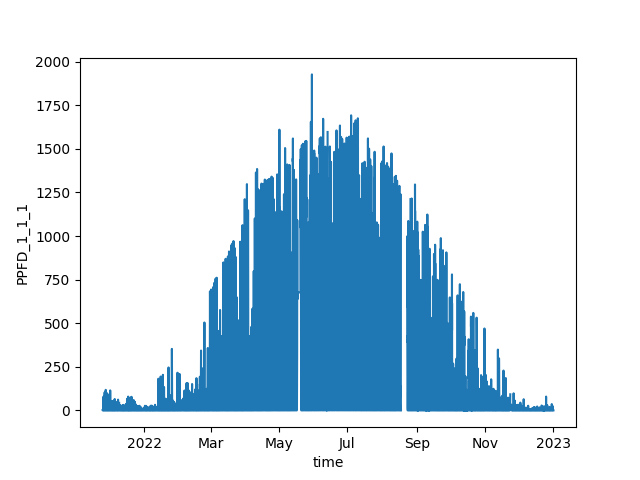

In [5]:
data.PPFD_1_1_1.plot()

## Load L3 data

L3 data is used to get the GPP variable

In [5]:
l3data = xr.open_dataset(f'{ONEDRIVE_FOLDER}EC/EC_flux_L3_final_FI-Ran_2022.nc')
l3data['time'] = pd.to_datetime(l3data.time, unit='d')

In [6]:
gpp = l3data.GPP_gf_ensemble_NT.to_dataframe()
gpp.head()

,GPP_gf_ensemble_NT
time,
2022-01-01 00:00:00,0.0
2022-01-01 00:30:00,0.0
2022-01-01 01:00:00,0.0
2022-01-01 01:30:00,0.0
2022-01-01 02:00:00,0.0


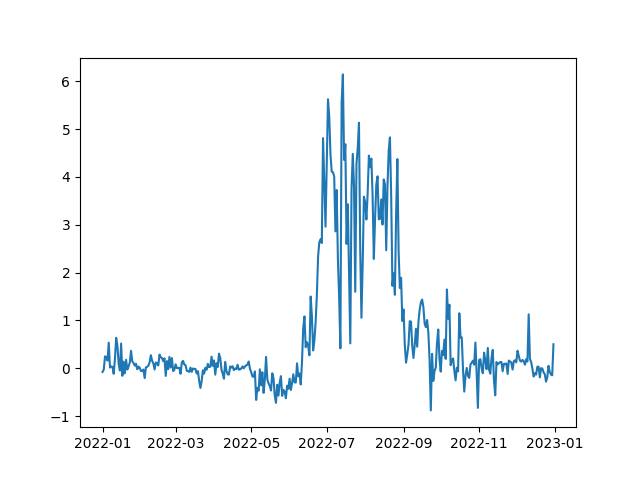

In [7]:
fig, ax = plt.subplots()
daily_mean = l3data.ch4_flux_final_gf_ensemble.resample(time='1D').mean()*1000
ax.plot(daily_mean.time, daily_mean)

In [8]:
daily_mean.sel(time=slice(datetime(2022,9,1), datetime(2022,12,31))).max()

<xarray.DataArray 'ch4_flux_final_gf_ensemble' ()>
array(1.64822602)

## Calculate cumulative yearly sums

In [9]:
def calculate_budget_time_series(series):
    return ((series*1800).sum()*1e-6/1e-4).data.flatten()[0] # mol/ha

In [10]:
M_co2 = 44.01/1000 #kg/mol
M_n2o = 44.013/1000 #kg/mol
M_ch4 = 16.04/1000 #kg/mol

GWP100_n2o = 265 #kgCO2eq/kgN2O
GWP100_ch4 = 28 #kgCO2eq/kgCH4

cumulative_flux_co2 = calculate_budget_time_series(l3data.co2_flux_final_gf_ensemble)
cumulative_flux_ch4 = calculate_budget_time_series(l3data.ch4_flux_final_gf_ensemble)
cumulative_flux_n2o = calculate_budget_time_series(l3data.n2o_flux_final_gf_ensemble)

print(f'CO2 cumulative flux: {cumulative_flux_co2*M_co2} kgCO2/ha')
print(f'CH4 cumulative flux: {cumulative_flux_ch4*M_ch4} kgCH4/ha = {cumulative_flux_ch4*M_ch4*GWP100_ch4} kgCO2/ha')
print(f'N2O cumulative flux: {cumulative_flux_n2o*M_n2o} kgN2O/ha = {cumulative_flux_n2o*M_n2o*GWP100_n2o} kgCO2/ha')

CO2 cumulative flux: 23308.16142420719 kgCO2/ha
CH4 cumulative flux: 3.6461408819756937 kgCH4/ha = 102.09194469531943 kgCO2/ha
N2O cumulative flux: 18.29184510680708 kgN2O/ha = 4847.338953303876 kgCO2/ha


In [12]:
total_budget = cumulative_flux_co2*M_co2 + cumulative_flux_ch4*M_ch4*GWP100_ch4 + cumulative_flux_n2o*M_n2o*GWP100_n2o

fraction_co2 = cumulative_flux_co2*M_co2 / total_budget
fraction_ch4 = cumulative_flux_ch4*M_ch4*GWP100_ch4 / total_budget
fraction_n2o = cumulative_flux_n2o*M_n2o*GWP100_n2o / total_budget

print(f'CO2 fraction of total budget: {fraction_co2*100} %')
print(f'CH4 fraction of total budget: {fraction_ch4*100} %')
print(f'N2O fraction of total budget: {fraction_n2o*100} %')

CO2 fraction of total budget: 82.4845979743658 %
CH4 fraction of total budget: 0.3612903163554027 %
N2O fraction of total budget: 17.154111709278812 %


In [13]:
82.5 + 0.4 + 17.1

100.0

In [89]:
12.011*1e-3/M_co2/10000*1000

0.027291524653487845

In [91]:
cumulative_flux_ch4*M_ch4*12.011*1e-3/M_ch4/10000*1000

0.27302866666714504

In [92]:
cumulative_flux_co2*M_co2 * 12.011*1e-3/M_co2/10000*1000

636.1152621362248

In [94]:
cumulative_flux_gpp = calculate_budget_time_series(l3data.GPP_gf_ensemble_NT)
cumulative_flux_reco = calculate_budget_time_series(l3data.Reco_gf_ensemble_NT)

In [95]:
cumulative_flux_gpp*M_co2

14926.561775248403

In [98]:
cumulative_flux_gpp*M_co2*12.011*1e-3/M_co2/10000*1000

407.36862868100104

In [96]:
cumulative_flux_reco*M_co2

38234.7231994556

In [101]:
2500/10

250.0

In [99]:
cumulative_flux_reco*M_co2*12.011*1e-3/M_co2/10000*1000

1043.483890817226

In [97]:
(cumulative_flux_reco - cumulative_flux_gpp)*M_co2

23308.161424207196

In [11]:
variables = ['n2o_flux_final', 'ch4_flux_final', 'co2_flux_final', 'TA_1_1_1']

In [11]:
data_fit = data[variables]

In [12]:
soil_classes = data.soil_class.to_numpy()

In [13]:
for i,soil_class in enumerate(soil_classes):
    data_fit[soil_class] = (["time"], data.fpr_contribution[i, :].to_numpy())

In [14]:
data_fit

<xarray.Dataset>
Dimensions:           (time: 19344)
Coordinates:
  * time              (time) datetime64[ns] 2021-11-24 ... 2022-12-31T23:30:00
Data variables: (12/14)
    n2o_flux_final    (time) float64 ...
    ch4_flux_final    (time) float64 ...
    co2_flux_final    (time) float64 ...
    TA_1_1_1          (time) float64 ...
    Fallen tree       (time) float64 nan nan nan nan ... 0.1968 0.201 0.1997
    Dry branch        (time) float64 nan nan nan nan ... 0.0273 0.02354 0.02339
    ...                ...
    Dark moss         (time) float64 nan nan nan ... 0.005428 0.00539 0.005541
    Green vegetation  (time) float64 nan nan nan nan ... 0.05362 0.05154 0.05357
    Ditch             (time) float64 nan nan nan nan ... 0.06343 0.06165 0.05043
    Tree              (time) float64 nan nan nan nan ... 0.01498 0.01423 0.01832
    Covered ditch     (time) float64 nan nan nan ... 0.00701 0.006386 0.00554
    Instruments       (time) float64 nan nan nan ... 3.277e-11 4.689e-09

In [15]:
data_df = data_fit.to_dataframe()

## Choose only the snow free period

In [16]:
snow_cover_end = datetime(2022,5,1)
snow_cover_start = datetime(2022,11,16)

In [17]:
data_df = data_df.loc[snow_cover_end:snow_cover_start, :]
gpp = gpp.loc[snow_cover_end:snow_cover_start]

In [18]:
data_df.head()

,n2o_flux_final,ch4_flux_final,co2_flux_final,TA_1_1_1,Fallen tree,Dry branch,Exposed peat,Light moss,Dark moss,Green vegetation,Ditch,Tree,Covered ditch,Instruments
time,,,,,,,,,,,,,,
2022-05-01 00:00:00,NaN,NaN,NaN,-0.7717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 00:30:00,NaN,NaN,NaN,-1.2116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 01:00:00,NaN,NaN,NaN,-1.2247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 01:30:00,NaN,NaN,NaN,-1.1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 02:00:00,NaN,NaN,NaN,-0.9068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
gpp.head()

,GPP_gf_ensemble_NT
time,
2022-05-01 00:00:00,0.0
2022-05-01 00:30:00,0.0
2022-05-01 01:00:00,0.0
2022-05-01 01:30:00,0.0
2022-05-01 02:00:00,0.0


## Rename columns

In [20]:
data_df = data_df.rename(columns={'TA_1_1_1':'T_air','n2o_flux_final':'F_N2O','ch4_flux_final':'F_CH4','co2_flux_final':'F_CO2'})

In [21]:
data_df

,F_N2O,F_CH4,F_CO2,T_air,Fallen tree,Dry branch,Exposed peat,Light moss,Dark moss,Green vegetation,Ditch,Tree,Covered ditch,Instruments
time,,,,,,,,,,,,,,
2022-05-01 00:00:00,NaN,NaN,NaN,-0.7717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 00:30:00,NaN,NaN,NaN,-1.2116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 01:00:00,NaN,NaN,NaN,-1.2247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 01:30:00,NaN,NaN,NaN,-1.1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 02:00:00,NaN,NaN,NaN,-0.9068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-15 22:00:00,0.000404,-0.000115,0.787602,-1.1274,0.174526,0.051282,0.322551,0.113539,0.007851,0.162817,0.055233,0.047430,0.026839,0.000135
2022-11-15 22:30:00,0.000555,0.000222,0.790709,-1.1688,0.176000,0.050487,0.337351,0.118190,0.007987,0.158843,0.046099,0.050064,0.020141,0.000033
2022-11-15 23:00:00,0.000471,-0.000249,0.755470,-1.2595,0.185566,0.055066,0.305336,0.124700,0.007887,0.158282,0.050083,0.046426,0.025571,0.000126


## Add logarithm columns of GHG fluxes

In [22]:
np.floor(data_df.F_N2O.min()*1000)

0.0

In [23]:
np.floor(data_df.F_CH4.min()*1000)

-10.0

In [24]:
data.n2o_flux_final

<xarray.DataArray 'n2o_flux_final' (time: 19344)>
[19344 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2021-11-24 ... 2022-12-31T23:30:00

In [25]:
np.floor(data_df.F_CH4.min()*1000)/1000

-0.01

In [26]:
data_df = data_df.assign(F_N2O_log = np.log((data_df.F_N2O - np.floor(data_df.F_N2O.min()*1000)/1000)))
data_df = data_df.assign(F_CH4_log = np.log((data_df.F_CH4 - np.floor(data_df.F_CH4.min()*1000)/1000)))
data_df = data_df.assign(F_CO2_log = np.log((data_df.F_CO2 - np.floor(data_df.F_CO2.min()*1000)/1000)))

## Add combined columns for surface types

In [27]:
data_df = data_df.assign(logging_residue = data_df.loc[:, 'Fallen tree'] + data_df.loc[:, 'Dry branch'])
data_df = data_df.assign(green_vegetations= data_df.loc[:, 'Green vegetation'] + data_df.loc[:, 'Tree'])
data_df = data_df.assign(ditches = data_df.loc[:, 'Ditch'] + data_df.loc[:, 'Covered ditch'])

## Set T_air to Kelvin

In [28]:
data_df = data_df.assign(T_air_K = data_df.T_air.values + 273.15)

# Correlation

In [29]:
data

<xarray.Dataset>
Dimensions:                     (time: 19344, soil_class: 10)
Coordinates:
  * time                        (time) datetime64[ns] 2021-11-24 ... 2022-12-...
  * soil_class                  (soil_class) <U16 'Fallen tree' ... 'Instrume...
Data variables: (12/103)
    H                           (time) float64 ...
    H_qf                        (time) float64 ...
    H_final                     (time) float64 ...
    rand_err_H                  (time) float64 ...
    LE                          (time) float64 ...
    LE_qf                       (time) float64 ...
    ...                          ...
    T_air_tomst_plot_3          (time) float64 ...
    soil_moisture_tomst_plot_3  (time) float64 ...
    T_soil_tomst_plot_4         (time) float64 ...
    T_surface_tomst_plot_4      (time) float64 ...
    T_air_tomst_plot_4          (time) float64 ...
    soil_moisture_tomst_plot_4  (time) float64 ...

In [57]:
data.wtd_odyssey_block6

<xarray.DataArray 'wtd_odyssey_block6' (time: 19344)>
[19344 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2021-11-24 ... 2022-12-31T23:30:00
Attributes:
    description:  WTD from odyssey logger (cm below soil surface)
    unit:         cm

In [60]:
variables = ['co2_flux_final', 'ch4_flux_final', 'n2o_flux_final','precipitation','PPFD_1_1_1','h2o_mixing_ratio','wtd_odyssey_block6','wtd_odyssey_block3','TA_1_1_1','T_soil_ac','T_soil_tomst_plot_2','T_soil_tomst_plot_3','T_soil_tomst_plot_4','T_surface_tomst_plot_2','T_surface_tomst_plot_3','T_surface_tomst_plot_4','T_air_tomst_plot_2','T_air_tomst_plot_3','T_air_tomst_plot_4','soil_moisture_ac','soil_moisture_tomst_plot_2','soil_moisture_tomst_plot_3','soil_moisture_tomst_plot_4']

In [61]:
data_env = data[variables].to_dataframe()

In [62]:
data_env = data_env.loc[snow_cover_end:snow_cover_start, :]

In [63]:
ind_gpp_in_data_env = gpp.index.get_indexer(data_env.index, method='nearest')

data_env.insert(1, 'GPP', gpp.iloc[ind_gpp_in_data_env].values)

In [34]:
data_env

,co2_flux_final,GPP,ch4_flux_final,n2o_flux_final,precipitation,PPFD_1_1_1,h2o_mixing_ratio,wtd_helena_block_6,wtd_helena_block_3,TA_1_1_1,...,T_surface_tomst_plot_2,T_surface_tomst_plot_3,T_surface_tomst_plot_4,T_air_tomst_plot_2,T_air_tomst_plot_3,T_air_tomst_plot_4,soil_moisture_ac,soil_moisture_tomst_plot_2,soil_moisture_tomst_plot_3,soil_moisture_tomst_plot_4
time,,,,,,,,,,,,,,,,,,,,,
2022-05-01 00:00:00,NaN,0.0,NaN,NaN,0.00,-0.0006,4.99596,-15.675000,-3.050000,-0.7717,...,-0.12,-0.31,0.38,0.25,0.44,0.56,0.32,56.00,65.30,17.7
2022-05-01 00:30:00,NaN,0.0,NaN,NaN,0.00,0.0025,5.00801,-15.735417,-3.041667,-1.2116,...,-0.38,-0.50,-0.25,-0.75,-0.59,-0.62,0.32,55.95,65.20,17.7
2022-05-01 01:00:00,NaN,0.0,NaN,NaN,0.00,0.0558,5.03225,-15.795833,-3.033333,-1.2247,...,-0.38,-0.56,-0.69,-1.25,-0.97,-1.25,0.32,55.85,65.10,17.7
2022-05-01 01:30:00,NaN,0.0,NaN,NaN,0.00,0.9863,5.07110,-15.856250,-3.025000,-1.1864,...,-0.69,-0.75,-1.16,-2.41,-1.94,-2.62,0.32,55.70,65.05,17.7
2022-05-01 02:00:00,NaN,0.0,NaN,NaN,0.00,5.7927,5.15785,-15.916667,-3.016667,-0.9068,...,-0.88,-0.94,-1.47,-3.09,-2.69,-3.56,0.32,55.45,64.95,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-15 22:00:00,0.787602,0.0,-0.000115,0.000404,0.00,-0.0014,5.31249,-25.950423,-1.958333,-1.1274,...,0.62,0.75,-0.22,-0.94,-0.84,-0.94,0.31,41.30,51.30,21.3
2022-11-15 22:30:00,0.790709,0.0,0.000222,0.000555,0.00,-0.0013,5.34765,-25.877120,-2.000000,-1.1688,...,0.62,0.75,-0.25,-1.00,-0.97,-1.06,0.31,41.30,51.30,21.3
2022-11-15 23:00:00,0.755470,0.0,-0.000249,0.000471,0.00,-0.0014,5.35559,-25.803817,-2.041667,-1.2595,...,0.56,0.69,-0.25,-1.06,-1.00,-1.12,0.31,41.20,51.30,21.3


In [35]:
data_env = data_env.rename(columns={'TA_1_1_1':'T_air','co2_flux_final': 'F_CO2', 'n2o_flux_final':'F_N2O','ch4_flux_final':'F_CH4','PPFD_1_1_1':'PPFD','h2o_mixing_ratio': 'w_H2O'})

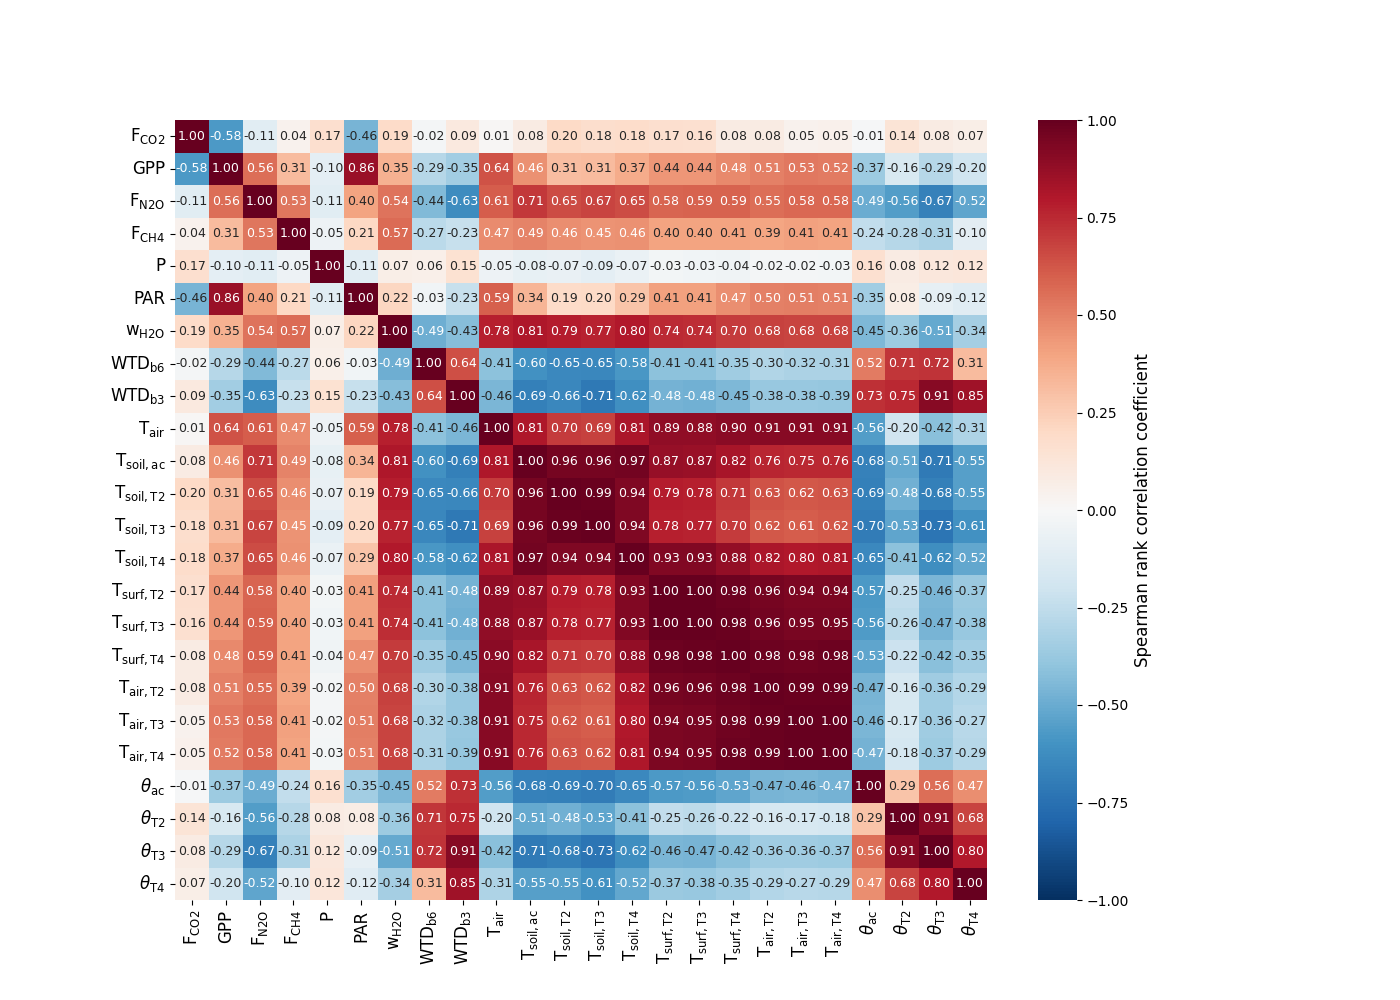

In [64]:
fig, ax = plt.subplots(figsize=(14,10))
fig.subplots_adjust(bottom=0.1, right=0.85)
hmp = sns.heatmap(data_env.corr(method='spearman'), cmap="RdBu_r", annot=True, fmt='.2f', 
                  ax=ax, annot_kws={'size': 9}, vmin=-1, vmax=1,
                  cbar_kws={'label': 'Spearman rank correlation coefficient'})
hmp.tick_params(axis='both', labelsize=12)


tick_texts = ['F$_{\mathrm{CO2}}$','GPP','F$_{\mathrm{N2O}}$','F$_{\mathrm{CH4}}$','P','PAR','w$_{\mathrm{H2O}}$','WTD$_{\mathrm{b6}}$', 'WTD$_{\mathrm{b3}}$',
              'T$_{\mathrm{air}}$', 'T$_{\mathrm{soil,ac}}$', 'T$_{\mathrm{soil,T2}}$', 'T$_{\mathrm{soil,T3}}$', 
              'T$_{\mathrm{soil,T4}}$', 'T$_{\mathrm{surf,T2}}$', 'T$_{\mathrm{surf,T3}}$', 'T$_{\mathrm{surf,T4}}$',
              'T$_{\mathrm{air,T2}}$', 'T$_{\mathrm{air,T3}}$', 'T$_{\mathrm{air,T4}}$', r'$\theta_{\mathrm{ac}}$',
              r'$\theta_{\mathrm{T2}}$',r'$\theta_{\mathrm{T3}}$',r'$\theta_{\mathrm{T4}}$'
              ]
labels = ax.get_xticklabels()
for i,label in enumerate(labels):
    label.set_text(tick_texts[i])
_ = ax.set_xticklabels(labels)

labels = ax.get_yticklabels()
for i,label in enumerate(labels):
    label.set_text(tick_texts[i])
_ = ax.set_yticklabels(labels)

hmp.figure.axes[-1].yaxis.label.set_size(12)

# Figure with mean Tomst data

In [65]:
data_env = data[variables].to_dataframe()

In [66]:
data_env = data_env.rename(columns={'TA_1_1_1':'T_air','co2_flux_final': 'F_CO2', 'n2o_flux_final':'F_N2O','ch4_flux_final':'F_CH4','PPFD_1_1_1':'PPFD','h2o_mixing_ratio': 'w_H2O'})

In [67]:
data_env = data_env.loc[snow_cover_end:snow_cover_start, :]

In [68]:
data_env.columns

Index(['F_CO2', 'F_CH4', 'F_N2O', 'precipitation', 'PPFD', 'w_H2O',
       'wtd_odyssey_block6', 'wtd_odyssey_block3', 'T_air', 'T_soil_ac',
       'T_soil_tomst_plot_2', 'T_soil_tomst_plot_3', 'T_soil_tomst_plot_4',
       'T_surface_tomst_plot_2', 'T_surface_tomst_plot_3',
       'T_surface_tomst_plot_4', 'T_air_tomst_plot_2', 'T_air_tomst_plot_3',
       'T_air_tomst_plot_4', 'soil_moisture_ac', 'soil_moisture_tomst_plot_2',
       'soil_moisture_tomst_plot_3', 'soil_moisture_tomst_plot_4'],
      dtype='object')

In [69]:
data_env = data_env.assign(T_air_tomst_mean = data_env.loc[:, ['T_air_tomst_plot_2', 'T_air_tomst_plot_3', 'T_air_tomst_plot_4']].mean(axis=1))
data_env = data_env.assign(T_surface_tomst_mean = data_env.loc[:, ['T_surface_tomst_plot_2', 'T_surface_tomst_plot_3', 'T_surface_tomst_plot_4']].mean(axis=1))
data_env = data_env.assign(T_soil_tomst_mean = data_env.loc[:, ['T_soil_tomst_plot_2', 'T_soil_tomst_plot_3', 'T_soil_tomst_plot_4']].mean(axis=1))

In [70]:
data_env = data_env.assign(soil_moisture_tomst_mean = data_env.loc[:, ['soil_moisture_tomst_plot_2', 'soil_moisture_tomst_plot_3', 'soil_moisture_tomst_plot_4']].mean(axis=1))

In [71]:
ind_gpp_in_data_env = gpp.index.get_indexer(data_env.index, method='nearest')

data_env.insert(1, 'GPP', gpp.iloc[ind_gpp_in_data_env].values)

In [72]:
data_env.columns

Index(['F_CO2', 'GPP', 'F_CH4', 'F_N2O', 'precipitation', 'PPFD', 'w_H2O',
       'wtd_odyssey_block6', 'wtd_odyssey_block3', 'T_air', 'T_soil_ac',
       'T_soil_tomst_plot_2', 'T_soil_tomst_plot_3', 'T_soil_tomst_plot_4',
       'T_surface_tomst_plot_2', 'T_surface_tomst_plot_3',
       'T_surface_tomst_plot_4', 'T_air_tomst_plot_2', 'T_air_tomst_plot_3',
       'T_air_tomst_plot_4', 'soil_moisture_ac', 'soil_moisture_tomst_plot_2',
       'soil_moisture_tomst_plot_3', 'soil_moisture_tomst_plot_4',
       'T_air_tomst_mean', 'T_surface_tomst_mean', 'T_soil_tomst_mean',
       'soil_moisture_tomst_mean'],
      dtype='object')

In [73]:
data_env_mean = data_env.loc[:, ['F_CO2', 'GPP', 'F_N2O', 'F_CH4', 'precipitation', 'PPFD', 'w_H2O', 'wtd_odyssey_block6',
       'wtd_odyssey_block3', 'T_air', 'T_soil_ac', 'T_soil_tomst_mean',
       'T_surface_tomst_mean',
       'T_air_tomst_mean',
       'soil_moisture_ac', 'soil_moisture_tomst_mean'],]

In [74]:
data_env_mean.columns

Index(['F_CO2', 'GPP', 'F_N2O', 'F_CH4', 'precipitation', 'PPFD', 'w_H2O',
       'wtd_odyssey_block6', 'wtd_odyssey_block3', 'T_air', 'T_soil_ac',
       'T_soil_tomst_mean', 'T_surface_tomst_mean', 'T_air_tomst_mean',
       'soil_moisture_ac', 'soil_moisture_tomst_mean'],
      dtype='object')

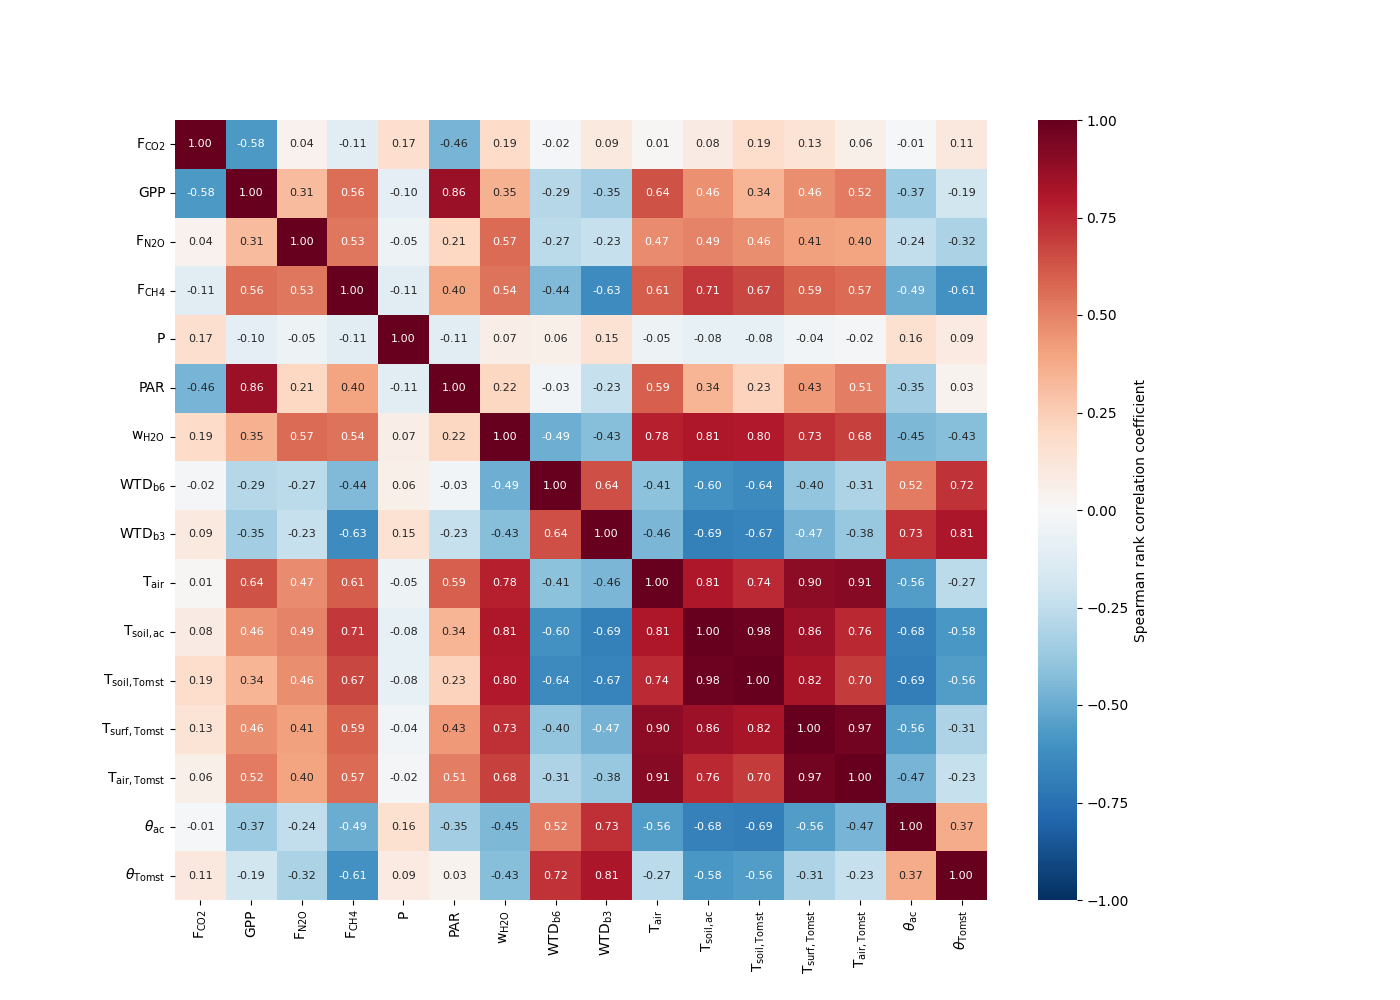

In [75]:
fig, ax = plt.subplots(figsize=(14,10))
fig.subplots_adjust(bottom=0.1, right=0.85)
hmp = sns.heatmap(data_env_mean.corr(method='spearman'), cmap="RdBu_r", annot=True, fmt='.2f', 
                  ax=ax, annot_kws={'size': 8}, vmin=-1, vmax=1,
                  cbar_kws={'label': 'Spearman rank correlation coefficient'})
hmp.tick_params(axis='both', labelsize=10)


tick_texts = ['F$_{\mathrm{CO2}}$','GPP','F$_{\mathrm{N2O}}$','F$_{\mathrm{CH4}}$','P','PAR','w$_{\mathrm{H2O}}$','WTD$_{\mathrm{b6}}$', 'WTD$_{\mathrm{b3}}$',
              'T$_{\mathrm{air}}$', 'T$_{\mathrm{soil,ac}}$', 'T$_{\mathrm{soil,Tomst}}$', 'T$_{\mathrm{surf,Tomst}}$',
              'T$_{\mathrm{air,Tomst}}$', r'$\theta_{\mathrm{ac}}$',
              r'$\theta_{\mathrm{Tomst}}$'
              ]
labels = ax.get_xticklabels()
for i,label in enumerate(labels):
    label.set_text(tick_texts[i])
_ = ax.set_xticklabels(labels)

labels = ax.get_yticklabels()
for i,label in enumerate(labels):
    label.set_text(tick_texts[i])
_ = ax.set_yticklabels(labels)

hmp.figure.axes[-1].yaxis.label.set_size(10)

# Correlation figure but only one T, $\theta$ and WTD

In [55]:
data_env.columns

Index(['F_CO2', 'GPP', 'F_CH4', 'F_N2O', 'precipitation', 'PPFD', 'w_H2O',
       'wtd_helena_block_6', 'wtd_helena_block_3', 'T_air', 'T_soil_ac',
       'T_soil_tomst_plot_2', 'T_soil_tomst_plot_3', 'T_soil_tomst_plot_4',
       'T_surface_tomst_plot_2', 'T_surface_tomst_plot_3',
       'T_surface_tomst_plot_4', 'T_air_tomst_plot_2', 'T_air_tomst_plot_3',
       'T_air_tomst_plot_4', 'soil_moisture_ac', 'soil_moisture_tomst_plot_2',
       'soil_moisture_tomst_plot_3', 'soil_moisture_tomst_plot_4',
       'T_air_tomst_mean', 'T_surface_tomst_mean', 'T_soil_tomst_mean',
       'soil_moisture_tomst_mean'],
      dtype='object')

In [76]:
data_env_manuscript = data_env.loc[:, ['F_CO2', 'GPP', 'F_CH4', 'F_N2O', 'precipitation', 'PPFD',
                                 'w_H2O', 'wtd_odyssey_block6', 'T_air', 'T_soil_tomst_mean', 'soil_moisture_tomst_mean'],]

In [77]:
data_env_manuscript.corr(method='spearman')

,F_CO2,GPP,F_CH4,F_N2O,precipitation,PPFD,w_H2O,wtd_odyssey_block6,T_air,T_soil_tomst_mean,soil_moisture_tomst_mean
F_CO2,1.000000,-0.577745,-0.111283,0.040473,0.167032,-0.462036,0.193686,-0.017703,0.012218,0.185025,0.109369
GPP,-0.577745,1.000000,0.555695,0.314800,-0.100890,0.863070,0.351741,-0.288095,0.640012,0.341282,-0.191863
F_CH4,-0.111283,0.555695,1.000000,0.534974,-0.110183,0.399954,0.544775,-0.441557,0.607781,0.669955,-0.607856
F_N2O,0.040473,0.314800,0.534974,1.000000,-0.049750,0.205321,0.567579,-0.271340,0.471468,0.463670,-0.315210
precipitation,0.167032,-0.100890,-0.110183,-0.049750,1.000000,-0.113352,0.066158,0.060532,-0.050207,-0.078256,0.091661
PPFD,-0.462036,0.863070,0.399954,0.205321,-0.113352,1.000000,0.215496,-0.031470,0.594606,0.230702,0.034017
w_H2O,0.193686,0.351741,0.544775,0.567579,0.066158,0.215496,1.000000,-0.488580,0.777210,0.797818,-0.428614
wtd_odyssey_block6,-0.017703,-0.288095,-0.441557,-0.271340,0.060532,-0.031470,-0.488580,1.000000,-0.412966,-0.637460,0.720523
T_air,0.012218,0.640012,0.607781,0.471468,-0.050207,0.594606,0.777210,-0.412966,1.000000,0.744723,-0.267965
T_soil_tomst_mean,0.185025,0.341282,0.669955,0.463670,-0.078256,0.230702,0.797818,-0.637460,0.744723,1.000000,-0.558298


In [78]:
corr = data_env_manuscript.corr(method='spearman').values

mask1 = ((np.abs(corr) <= 0.25))
mask2 = np.triu(corr) != 0

mask = mask1 | mask2

In [79]:
data_env_manuscript.corr(method='spearman').abs() < 0.25

,F_CO2,GPP,F_CH4,F_N2O,precipitation,PPFD,w_H2O,wtd_odyssey_block6,T_air,T_soil_tomst_mean,soil_moisture_tomst_mean
F_CO2,False,False,True,True,True,False,True,True,True,True,True
GPP,False,False,False,False,True,False,False,False,False,False,True
F_CH4,True,False,False,False,True,False,False,False,False,False,False
F_N2O,True,False,False,False,True,True,False,False,False,False,False
precipitation,True,True,True,True,False,True,True,True,True,True,True
PPFD,False,False,False,True,True,False,True,True,False,True,True
w_H2O,True,False,False,False,True,True,False,False,False,False,False
wtd_odyssey_block6,True,False,False,False,True,True,False,False,False,False,False
T_air,True,False,False,False,True,False,False,False,False,False,False
T_soil_tomst_mean,True,False,False,False,True,True,False,False,False,False,False


In [80]:
data_env_manuscript.corr(method='spearman')

,F_CO2,GPP,F_CH4,F_N2O,precipitation,PPFD,w_H2O,wtd_odyssey_block6,T_air,T_soil_tomst_mean,soil_moisture_tomst_mean
F_CO2,1.000000,-0.577745,-0.111283,0.040473,0.167032,-0.462036,0.193686,-0.017703,0.012218,0.185025,0.109369
GPP,-0.577745,1.000000,0.555695,0.314800,-0.100890,0.863070,0.351741,-0.288095,0.640012,0.341282,-0.191863
F_CH4,-0.111283,0.555695,1.000000,0.534974,-0.110183,0.399954,0.544775,-0.441557,0.607781,0.669955,-0.607856
F_N2O,0.040473,0.314800,0.534974,1.000000,-0.049750,0.205321,0.567579,-0.271340,0.471468,0.463670,-0.315210
precipitation,0.167032,-0.100890,-0.110183,-0.049750,1.000000,-0.113352,0.066158,0.060532,-0.050207,-0.078256,0.091661
PPFD,-0.462036,0.863070,0.399954,0.205321,-0.113352,1.000000,0.215496,-0.031470,0.594606,0.230702,0.034017
w_H2O,0.193686,0.351741,0.544775,0.567579,0.066158,0.215496,1.000000,-0.488580,0.777210,0.797818,-0.428614
wtd_odyssey_block6,-0.017703,-0.288095,-0.441557,-0.271340,0.060532,-0.031470,-0.488580,1.000000,-0.412966,-0.637460,0.720523
T_air,0.012218,0.640012,0.607781,0.471468,-0.050207,0.594606,0.777210,-0.412966,1.000000,0.744723,-0.267965
T_soil_tomst_mean,0.185025,0.341282,0.669955,0.463670,-0.078256,0.230702,0.797818,-0.637460,0.744723,1.000000,-0.558298


In [81]:
res = spearmanr(data_env_manuscript, nan_policy='omit')

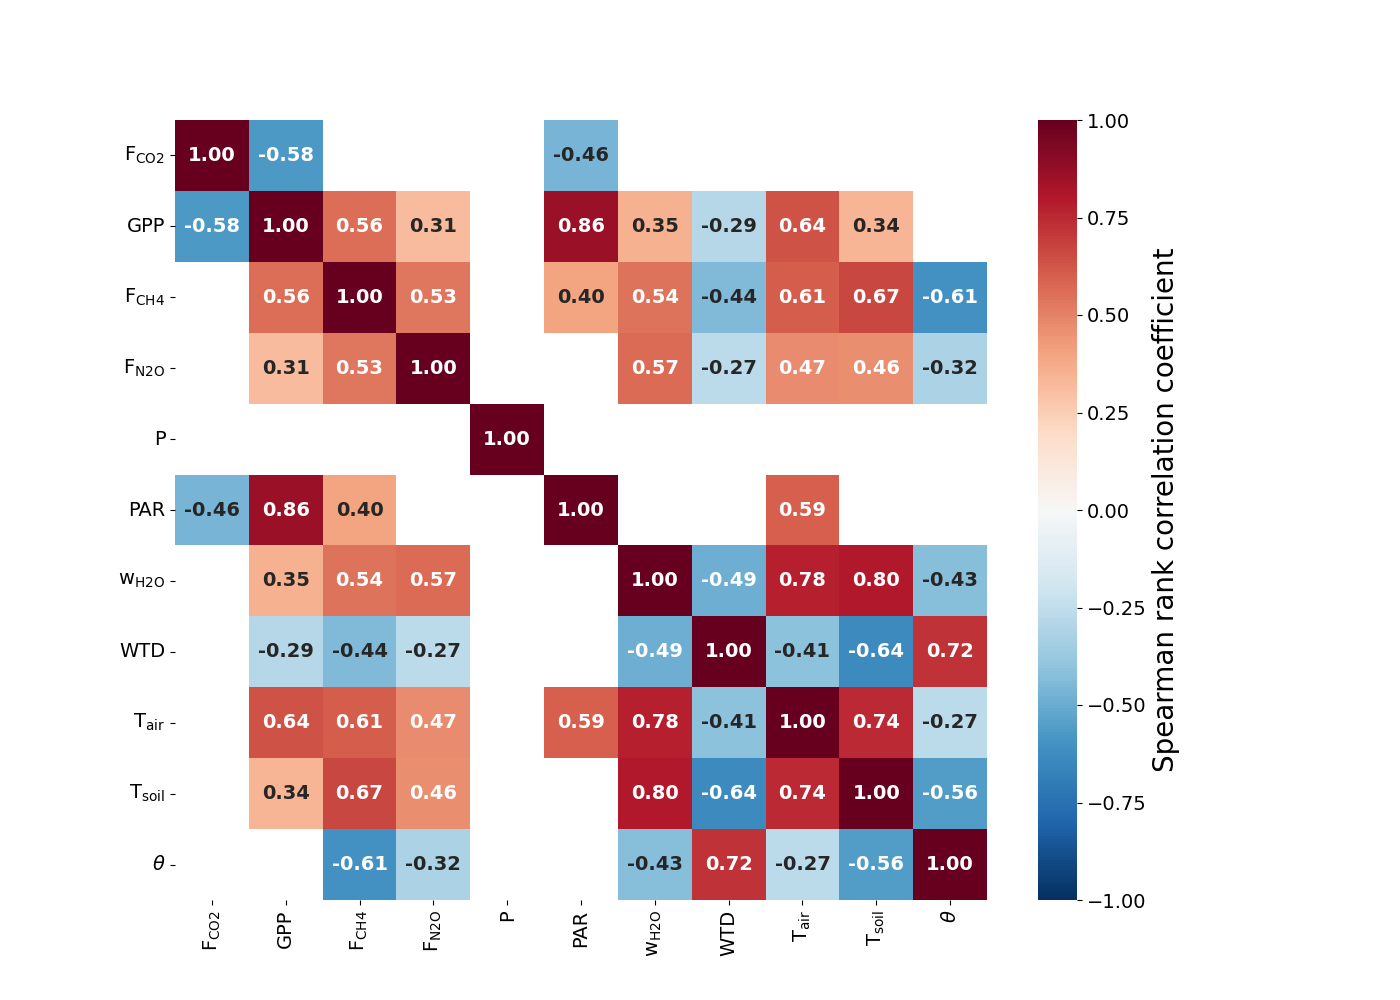

In [82]:
fig, ax = plt.subplots(figsize=(14,10))
fig.subplots_adjust(bottom=0.1, right=0.85)
hmp = sns.heatmap(data_env_manuscript.corr(method='spearman'), cmap="RdBu_r", annot=True, fmt='.2f', 
                  ax=ax, annot_kws={'size': 14, 'weight': 'bold'}, vmin=-1, vmax=1,
                  cbar_kws={'label': 'Spearman rank correlation coefficient'}, mask=mask1)
hmp.tick_params(axis='both', labelsize=14)


tick_texts = ['F$_{\mathrm{CO2}}$','GPP','F$_{\mathrm{CH4}}$', 'F$_{\mathrm{N2O}}$','P','PAR','w$_{\mathrm{H2O}}$','WTD',
              'T$_{\mathrm{air}}$', 'T$_{\mathrm{soil}}$', r'$\theta$'
              ]
labels = ax.get_xticklabels()
for i,label in enumerate(labels):
    label.set_text(tick_texts[i])
_ = ax.set_xticklabels(labels)

labels = ax.get_yticklabels()
for i,label in enumerate(labels):
    label.set_text(tick_texts[i])
_ = ax.set_yticklabels(labels)

hmp.figure.axes[-1].yaxis.label.set_size(20)
hmp.figure.axes[-1].tick_params(axis='y', labelsize=14)